In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
%matplotlib inline

In [2]:
tf.random.set_seed(272)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False

In [3]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

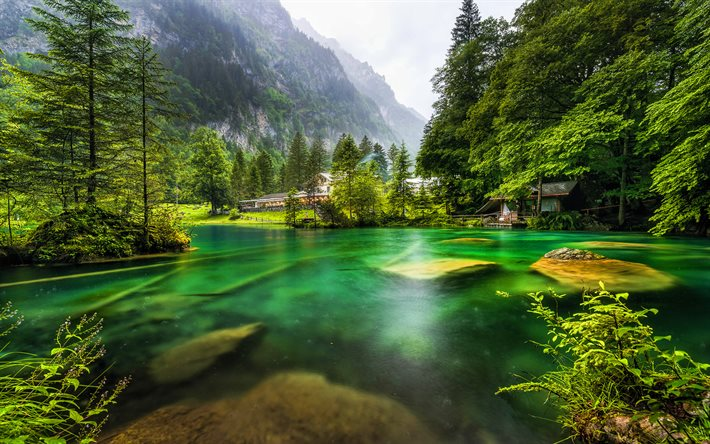

In [12]:
content_path = "content/swiss.jpg"
content_image = Image.open(content_path)
content_image

In [5]:
def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, [m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, [m, -1, n_C])
    
    J_content = (.25 / float(int(n_H * n_W * n_C))) * tf.reduce_sum(tf.square(tf.subtract(a_G_unrolled , a_C_unrolled)))
    
    return J_content

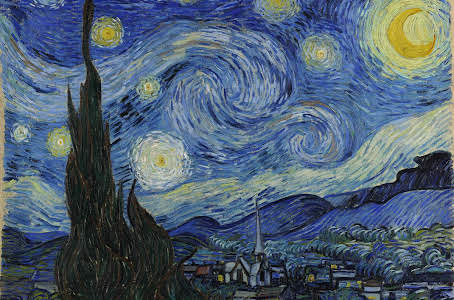

In [13]:
style_path = "style/starry-night.jpg"
style = Image.open(style_path)
style

In [14]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [15]:
def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = ((.5 / (n_H * n_W * n_C)) ** 2) * tf.reduce_sum(tf.square(tf.subtract(GS , GG)))

    return J_style_layer

In [16]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [17]:
STYLE_LAYERS = [
    ('block1_conv1', 0.3),
    ('block2_conv1', 0.5),
    ('block3_conv1', 0.1),
    ('block4_conv1', 0.05),
    ('block5_conv1', 0.05)
]

In [18]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    J_style = 0
    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

In [30]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

(1, 400, 400, 3)


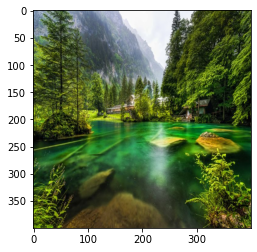

In [20]:
content_image = np.array(Image.open(content_path).resize((img_size, img_size)))
content_image = tf.constant(np.expand_dims(content_image,axis=0))

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


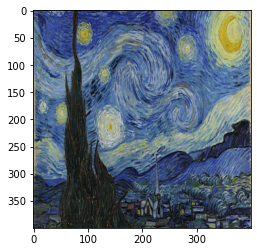

In [21]:
style_image =  np.array(Image.open(style_path).resize((img_size, img_size)))
style_image = tf.constant(np.expand_dims(style_image,axis=0))

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


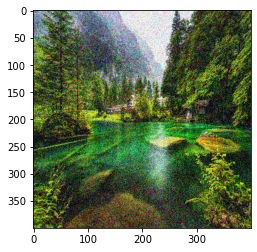

In [22]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.3, 0.3)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

In [23]:
content_layer = [('block5_conv4', 1)]
outputs = [vgg.get_layer(layer[0]).output for layer in STYLE_LAYERS+content_layer]
vgg_model = tf.keras.Model([vgg.input], outputs)

In [24]:
vgg_model.output

[<KerasTensor: shape=(None, 400, 400, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 200, 200, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 100, 100, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 50, 50, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv1')>,
 <KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>]

In [25]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model(preprocessed_content)

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model(preprocessed_style)

In [26]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 200001

@tf.function()
def train(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model(generated_image)
        J_style = compute_style_cost(a_S,a_G,STYLE_LAYERS)
        J_content = compute_content_cost(a_C,a_G)
        J = total_cost(J_content,J_style, alpha=10, beta=40)
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

for i in range(epochs):
    train(generated_image)
    if i % 2000 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        plt.show() 
image.save(f"out/new_image_{style_path[6:]}")

ValueError: in user code:

    File "C:\Users\HOME\AppData\Local\Temp/ipykernel_3404/525467911.py", line 12, in train  *
        optimizer.apply_gradients([(grad, generated_image)])
    File "C:\Users\HOME\Desktop\collegeML\od\TFODCourse\tfod\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 633, in apply_gradients  **
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "C:\Users\HOME\Desktop\collegeML\od\TFODCourse\tfod\lib\site-packages\keras\optimizer_v2\utils.py", line 73, in filter_empty_gradients
        raise ValueError(f"No gradients provided for any variable: {variable}. "

    ValueError: No gradients provided for any variable: (['generated_image:0'],). Provided `grads_and_vars` is ((None, <tf.Tensor 'generated_image:0' shape=(1, 400, 400, 3) dtype=float32>),).
